# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Описание данных

### Features:

* **DateCrawled** - дата скачивания анкеты из базы
* **VehicleType** - тип автомобиля кузова
* **RegistrationYear**- год регистрации автомобиля
* **Gearbox** - тип коробки передач 
* **Power** - мощность
* **Model** - модель автомобиля
* **Kilometer** - пробег
* **RegistrationMonth** - месяц регистрации автомобиля
* **FuelType** - тип кузова
* **Brand** - марка автомобиля 
* **Repaired** - была ли машина в ремонте или нет
* **DateCreated** - дата создания анкеты
* **NumberOfPictures** - количество фотографий автомобиля
* **PostalCode** - почтовый индекс владельца анкеты(пользователя)
* **LastSeen** - дата последней активности пользователя

### Train:

**Price** - цена

## Осмотр и подготовка данных

### Импорт библиотек:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split

from  sklearn.preprocessing import OrdinalEncoder
# from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import GridSearchCV
from math import sqrt



from catboost import CatBoostRegressor, Pool
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression


plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')
plt.rcParams.update({'font.size': 12})

import time

### Загрузка данных

In [2]:
dt = pd.read_csv('/datasets/autos.csv')

## Общий осмотр данных

### describe

In [3]:
display(dt.head(3), dt.describe(), 'Размерность датасета:',dt.shape)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46


,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


'Размерность датасета:'

(354369, 16)

### int-columns Histogram

array([[<AxesSubplot:title={'center':'Price'}>,
        <AxesSubplot:title={'center':'RegistrationYear'}>,
        <AxesSubplot:title={'center':'Power'}>],
       [<AxesSubplot:title={'center':'Kilometer'}>,
        <AxesSubplot:title={'center':'RegistrationMonth'}>,
        <AxesSubplot:title={'center':'NumberOfPictures'}>],
       [<AxesSubplot:title={'center':'PostalCode'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

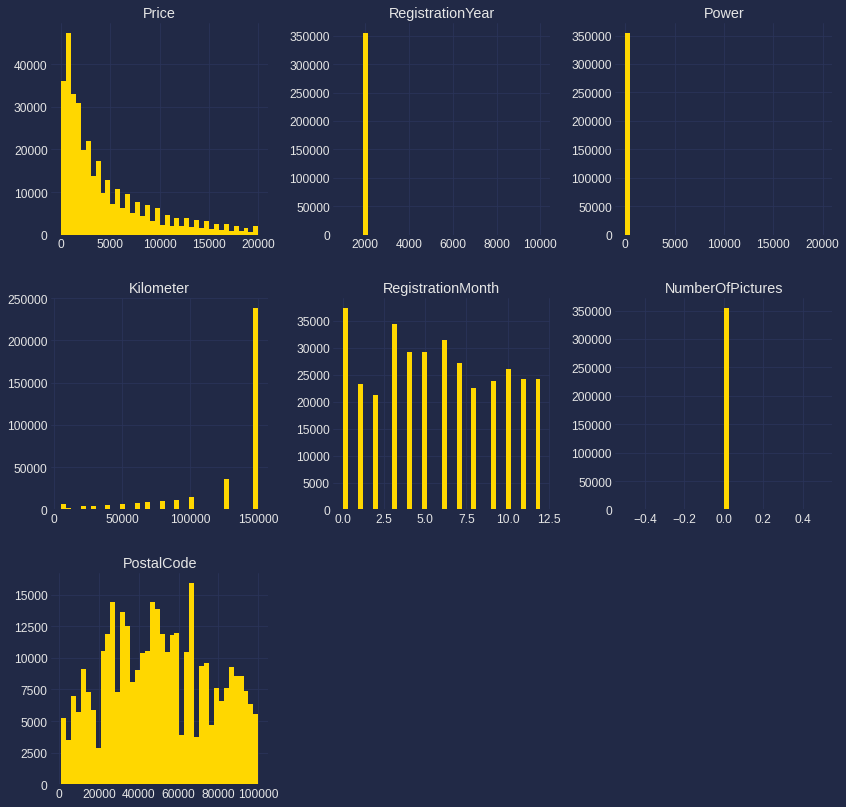

In [4]:
dt.hist(figsize = [14,14], color = 'gold', alpha = 1,bins = 40)


### Подсчет нулей:

In [5]:
dt.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

### Дубликаты

In [6]:
dt.duplicated().sum()

4

In [7]:
dt[dt.duplicated() == True]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15


In [8]:
dt_without = dt.drop(columns = ['PostalCode'])

In [9]:
dt_without.duplicated().sum()

5

### Максимумы уникальных значений:


In [10]:
dt_columns = [k for k in dt.columns]
for k in range(len(dt_columns)):
    display(dt[dt_columns[k]].value_counts().sort_values(ascending = False).head(5))

2016-03-24 14:49:47    7
2016-03-26 22:57:31    6
2016-03-19 21:49:56    6
2016-04-01 19:25:23    5
2016-03-05 14:44:30    5
Name: DateCrawled, dtype: int64

0       10772
500      5670
1500     5394
1000     4649
1200     4594
Name: Price, dtype: int64

sedan          91457
small          79831
wagon          65166
bus            28775
convertible    20203
Name: VehicleType, dtype: int64

2000    24490
1999    22728
2005    22109
2001    20124
2006    19900
Name: RegistrationYear, dtype: int64

manual    268251
auto       66285
Name: Gearbox, dtype: int64

0      40225
75     24023
60     15897
150    14590
101    13298
Name: Power, dtype: int64

golf     29232
other    24421
3er      19761
polo     13066
corsa    12570
Name: Model, dtype: int64

150000    238209
125000     36454
100000     14882
90000      11567
80000      10047
Name: Kilometer, dtype: int64

0    37352
3    34373
6    31508
4    29270
5    29153
Name: RegistrationMonth, dtype: int64

petrol      216352
gasoline     98720
lpg           5310
cng            565
hybrid         233
Name: FuelType, dtype: int64

volkswagen       77013
opel             39931
bmw              36914
mercedes_benz    32046
audi             29456
Name: Brand, dtype: int64

no     247161
yes     36054
Name: Repaired, dtype: int64

2016-04-03 00:00:00    13719
2016-04-04 00:00:00    13317
2016-03-20 00:00:00    12918
2016-03-12 00:00:00    12840
2016-03-21 00:00:00    12691
Name: DateCreated, dtype: int64

0    354369
Name: NumberOfPictures, dtype: int64

10115    819
65428    613
66333    343
32257    317
44145    317
Name: PostalCode, dtype: int64

2016-04-06 13:45:54    17
2016-04-07 09:44:27    16
2016-04-06 08:46:30    16
2016-04-06 09:17:58    16
2016-04-07 05:44:30    16
Name: LastSeen, dtype: int64

## Индивидуальный осмотр:

### Обработка столбцов отображающих даты:

In [11]:
# еще раз взгляним на столбцы признаков
dt.head(2)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50


* DateCrewled - дата скачивания анкеты из бызы
* RegistrationYear - год регистрации автомобиля
* RegistrationMonth - месяц регистрации автомобиля
* DateCreated - дата создания анкеты
* LastSeen - дата последне активности пользователя

Из столбцов выше можно утверддительно предположить:
1. LastSeen - признак будущего времени, кторый  может показать срок продажи авто, а не его стоимость
2. DateCrewled - признак будущего времени, которой не связан с ценой автомобила
3. DateCreated - признак не влияющий на цену автомобиля

Что можно сделать?
* Без уникального id пользователя, предполагая, что LastSeen - последний день его активности по этой анкете, можно вывести возраст автомобиля в момент его продажи. (DateCreated менее показателен для машин, которые не продались в первое время по стартовой цене. Т.е. он не учитывает динамику изменения цены в отсутствии спроса на предложение продавца):
1. С использованием LastSeen & RegistrationYear+RegistrationMonth - выведем возраст автомобиля 
2. Впоследствии удалить признаки будущего времени: DateCrewled, DateCreated, LastSeen.  Признаки, которые преобразуются в возарст автомобиля: RegistrationMonth , RegistrationYear

In [12]:
# приводим столбец к виду datetime
dt['LastSeen'] = pd.to_datetime(dt['LastSeen'])

In [13]:
# создаем столбцы с датой и месяцем продажи:
dt['sale_year'] = pd.DatetimeIndex(dt['LastSeen']).year
dt['sale_month'] = pd.DatetimeIndex(dt['LastSeen']).month

**Удаление выбросов**

**Год регистрации:**

<AxesSubplot:>

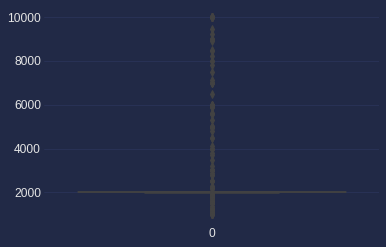

In [14]:
sns.boxplot(data = dt['RegistrationYear'])

Cмотрим максимальный\минимальный год закрытия заказа:

In [15]:
print(dt['sale_year'].max())
print(dt['sale_year'].min())

2016
2016


отсекаем верхний предел регистрации автомобиля:

<AxesSubplot:>

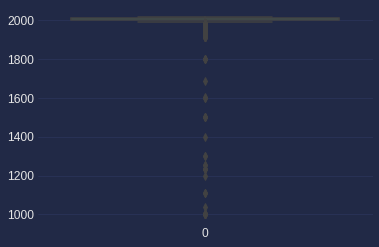

In [16]:
dt = dt.query('RegistrationYear < 2017')
sns.boxplot(data = dt['RegistrationYear'])

Ограничим нижний порог автомобилей:

In [17]:
for i in range(1950,2000,5):
    print('Год:',i, 'Количество авто:',dt[dt['RegistrationYear'] < i].shape[0])

Год: 1950 Количество авто: 246
Год: 1955 Количество авто: 310
Год: 1960 Количество авто: 422
Год: 1965 Количество авто: 818
Год: 1970 Количество авто: 1338
Год: 1975 Количество авто: 2393
Год: 1980 Количество авто: 3452
Год: 1985 Количество авто: 5448
Год: 1990 Количество авто: 9669
Год: 1995 Количество авто: 26518


In [18]:
dt = dt.query('RegistrationYear > 1970')

<AxesSubplot:>

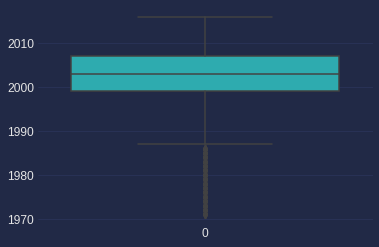

In [19]:
sns.boxplot(data = dt['RegistrationYear'])

**Месяц регистрации автомобиля:**

13


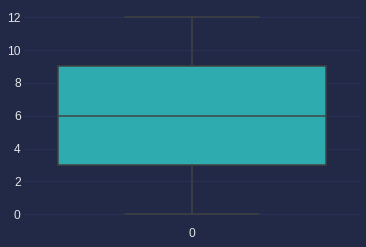

In [20]:
sns.boxplot(data = dt['RegistrationMonth'])
print(len(dt['RegistrationMonth'].unique()))

Просмотр аномального столбца, с нулевым месяцем:

In [21]:
display(dt[dt['RegistrationMonth'] == 0].head(3))
print('Количество нулей:',dt[dt['RegistrationMonth'] == 0].shape[0])

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen,sale_year,sale_month
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57,2016,4
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06,2016,3
16,2016-04-01 12:46:46,300,NaN,2016,NaN,60,polo,150000,0,petrol,volkswagen,NaN,2016-04-01 00:00:00,0,38871,2016-04-01 12:46:46,2016,4


Количество нулей: 33143


Предположим: подобное значени заполнялось в связи с незнанием или нежеланием заполнять месяц, что не является выбросом.

<AxesSubplot:>

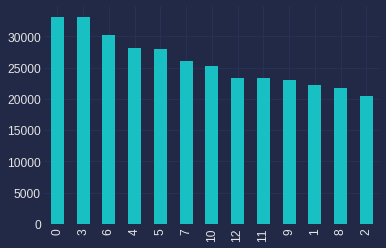

In [22]:
dt['RegistrationMonth'].value_counts().plot(kind = 'bar')

Не хочется увеличивать значение конкретного значения на 30.000 образцов, но с учётом будущего обращения всех столбцов date в единый показатель возраста машины, состоящего из количества месяцев-возраста, для уменьшения дисперсии возраста - вольём их в 6'ой месяц.

In [23]:
#созраним показатель неизменённого месяца, для подстраховки части значений в будущем показателе
dt['rm'] = dt['RegistrationMonth']

In [24]:
dt.loc[dt['RegistrationMonth'] == 0, 'RegistrationMonth'] = 6

**Создание нового столбца**

In [25]:
# посчитаем взраст машины в месяцах 
dt['age'] =   ((dt['sale_year'] - dt['RegistrationYear']) * 12) + (dt['sale_month'] - dt['RegistrationMonth'])

**Обработка отклонений**

In [26]:
# смотрим количество машин с отрицательным возрастом:
(dt['age'] < 0).sum()

7786

Часть этих значений появилась вследствии заполнения нулевого месяца значением 6. Исправим эту ситуацию:

In [27]:
#  проверим, строки в образовании которых виноваты мы rm == 0 and age < 0
dt.loc[(dt['rm'] == 0)&(dt['age'] <0), 'RegistrationMonth'].shape[0]


2753

In [28]:
# визуальный осмотр данных с отрицательным годом
dt.loc[dt["age"] < 0].head(3)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen,sale_year,sale_month,rm,age
16,2016-04-01 12:46:46,300,NaN,2016,NaN,60,polo,150000,6,petrol,volkswagen,NaN,2016-04-01 00:00:00,0,38871,2016-04-01 12:46:46,2016,4,0,-2
31,2016-03-29 16:57:02,899,NaN,2016,manual,60,clio,150000,6,petrol,renault,NaN,2016-03-29 00:00:00,0,37075,2016-03-29 17:43:07,2016,3,6,-3
35,2016-03-08 07:54:46,350,NaN,2016,manual,75,golf,150000,4,petrol,volkswagen,no,2016-03-08 00:00:00,0,19386,2016-03-08 09:44:50,2016,3,4,-1


In [29]:
# удалим данные с отрицательным возрастом машин:
dt = dt.query('age > 0')

Text(0, 0.5, 'Частота')

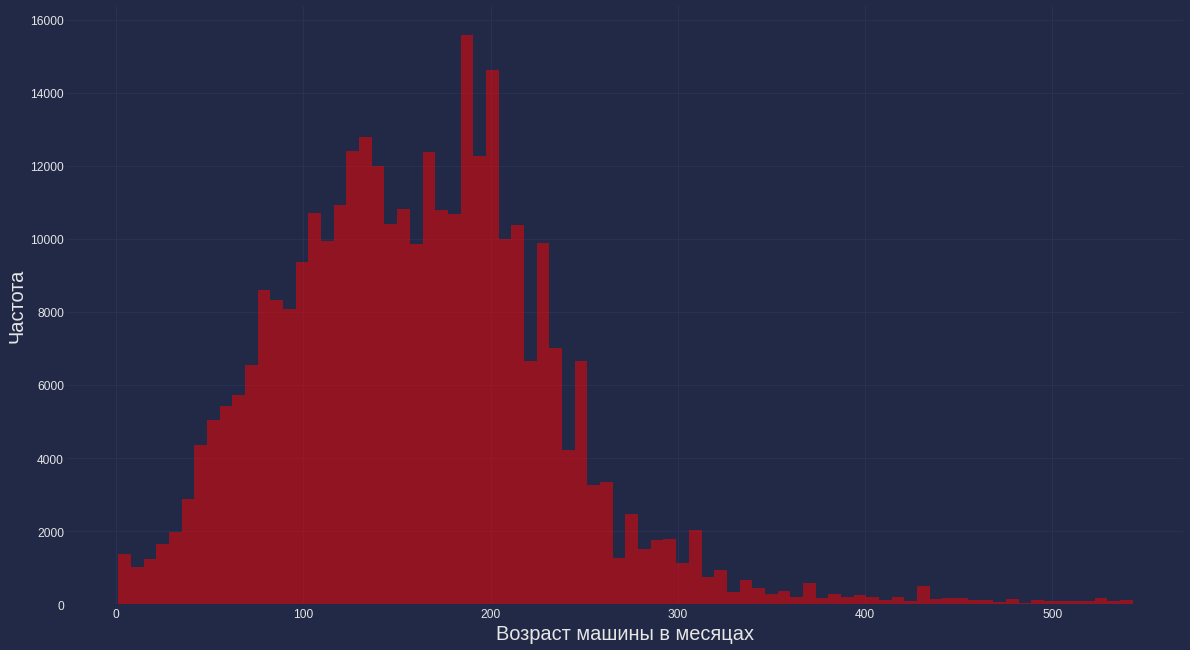

In [30]:
dt['age'].plot(kind = 'hist', bins = 80, alpha = 0.5, color = 'r', figsize = [20,11])
plt.xlabel('Возраст машины в месяцах', fontsize = 20)
plt.ylabel('Частота', fontsize = 20)


**Удаление столбцов**


In [31]:
c = ['DateCrawled','RegistrationYear','RegistrationMonth'
                            ,'DateCreated','LastSeen','rm','sale_year','sale_month']
dt_drop_columns = dt.loc[:,c]
dt = dt.drop(columns = c)

### Price

<AxesSubplot:ylabel='Frequency'>

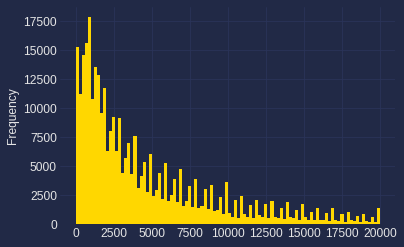

In [32]:
dt['Price'].plot(kind = 'hist', bins = 100, color = 'gold')

In [33]:
for i in range(0,301,50):
    print('Значений меньше или равно',i,':',dt[dt['Price'] <= i].shape[0])

Значений меньше или равно 0 : 9257
Значений меньше или равно 50 : 11004
Значений меньше или равно 100 : 12451
Значений меньше или равно 150 : 14436
Значений меньше или равно 200 : 17042
Значений меньше или равно 250 : 19495
Значений меньше или равно 300 : 22809


In [34]:
for i in range(10000,20001,2000):
    print('Значений больше или равно',i,':',dt[dt['Price'] >= i].shape[0])

Значений больше или равно 10000 : 42609
Значений больше или равно 12000 : 30178
Значений больше или равно 14000 : 19485
Значений больше или равно 16000 : 11130
Значений больше или равно 18000 : 4950
Значений больше или равно 20000 : 252


In [35]:
dt[dt['Price'] == 20000].tail(4)

,Price,VehicleType,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired,NumberOfPictures,PostalCode,age
342303,20000,sedan,manual,194,insignia,60000,gasoline,opel,no,0,76698,30
348208,20000,sedan,auto,241,lancer,40000,petrol,mitsubishi,no,0,97737,62
349230,20000,bus,auto,204,viano,125000,gasoline,mercedes_benz,no,0,55232,99
354045,20000,coupe,auto,476,other,125000,petrol,mercedes_benz,no,0,38118,116


In [36]:
dt[dt['Price'] < 10].head(4)

,Price,VehicleType,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired,NumberOfPictures,PostalCode,age
7,0,sedan,manual,50,other,40000,petrol,volkswagen,no,0,19348,428
40,0,NaN,NaN,0,corsa,150000,petrol,opel,NaN,0,56412,314
59,1,suv,manual,286,NaN,150000,NaN,sonstige_autos,NaN,0,53721,257
89,1,sedan,manual,113,e_klasse,150000,gasoline,mercedes_benz,no,0,40589,252


Машины дешевле 100$ смотрятся крайне сомнительно. Возможно продажа идёт в формате аукциона, но даже так сложно оправдать нулевую цену.

Для сохранения объема данных - не будем сильно урезать края, темболее верх может совпадать с реальной картиной вещей.

In [37]:
dt = dt.query('Price > 100')

### VehicleType

<AxesSubplot:>

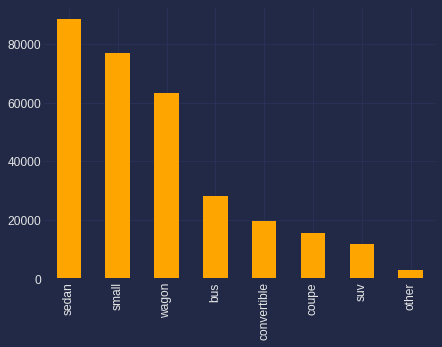

In [38]:
dt['VehicleType'].value_counts().plot(kind = 'bar', color = 'orange', figsize = [7,5])

In [39]:
dt['VehicleType'].isna().sum()

10729

Значений достаточно много,чтобы расскидывать их в конкретные параметры.


Пропуски будут заменены переменной 'Unknow' с предположения, что отсутствие данного параметра может повлиять на цену

In [40]:
dt.loc[dt['VehicleType'].isna()== True, 'VehicleType'] = 'unkonw'

### Gearbox

<AxesSubplot:>

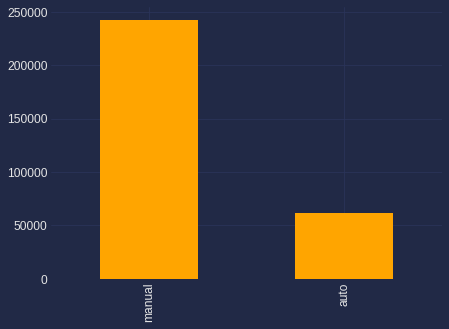

In [41]:
dt['Gearbox'].value_counts().plot(kind = 'bar', color = 'orange',figsize = [7,5])

In [42]:
dt['Gearbox'].isna().sum()

12968

Пропуски заменены переменной - указателем на отсутствиие информации по пункту.

In [43]:
dt.loc[dt['Gearbox'].isna()== True, 'Gearbox'] = 'unkonw'

### **Power**

<AxesSubplot:>

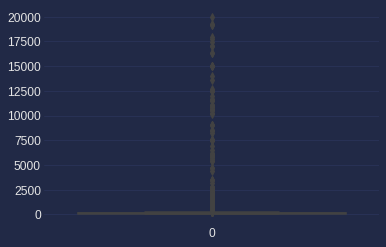

In [44]:
sns.boxplot(data = dt['Power'])

In [45]:
dt['Power'].isna().sum()

0

In [46]:
dt[dt['Power'] == 0].shape[0]

28483

Огромное число нулей и ракетные мощности.

* Заменим нули и выдающиеся значения средними показателями по каждой марке автомобиля

In [47]:
dt.loc[dt['Power'] == 0,'Repaired'].value_counts()

no     11094
yes     3395
Name: Repaired, dtype: int64

In [49]:
"""По модели можно предсказать бренд, 
а без бренда - нельзя предсказать модель. 
Нам важно знать, что слияние столбцов без модели даст NaN,
а без бренда не останется. Тогда не нужна предварительная обработка""" 
dt['Brand'].isna().sum()

0

In [50]:
# сольём модель + бренд
dt['BM'] = dt['Brand'] + '_' + dt['Model']
# добавим новый столбец с группировкой мощности двигателя по модели
dt['Power_means'] = dt.groupby('BM')['Power'].transform('mean')

In [51]:
dt.loc[dt['Power'] > 700, 'Power'] = dt.loc[dt['Power'] > 700, 'Power_means']
dt.loc[dt['Power'] < 20, 'Power'] = dt.loc[dt['Power'] < 20, 'Power_means']
dt.loc[dt['Power'].isna()==True, 'Power'] = dt.loc[dt['Power'].isna() == True, 'Power_means']

<AxesSubplot:>

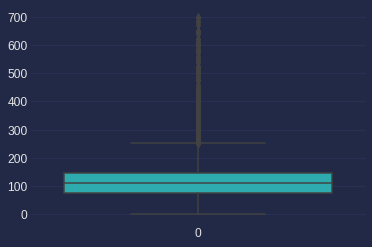

In [52]:
sns.boxplot(data = dt['Power'])

Посмотрим оставшиеся нули:

In [53]:
dt['Power'].isna().sum()

3666

In [54]:
dt[dt['Power'].isna() == True].head(2)

,Price,VehicleType,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired,NumberOfPictures,PostalCode,age,BM,Power_means
160,500,small,manual,NaN,NaN,150000,petrol,renault,no,0,26969,202,NaN,NaN
260,450,unkonw,manual,NaN,NaN,150000,petrol,mitsubishi,no,0,59302,1,NaN,NaN


удалим значения с отсутствием марки:

In [55]:
dt = dt.dropna(subset = ['Power'])
dt['Power'].isna().sum()

0

In [56]:
# Посмотрим тип данных на последок
dt['Power'].dtype

dtype('float64')

Изменим тип данных в переменной:

In [57]:
dt['Power'] = dt['Power'].astype(int)

###  Model

In [58]:
dt['Model'].isna().sum()

9912

в целом, неизвестные модели можно прировнять общему для всех виду: other

In [59]:
dt.loc[dt['Model'].isna()== True, 'Model'] = 'other'

### Kilometer

<AxesSubplot:ylabel='Frequency'>

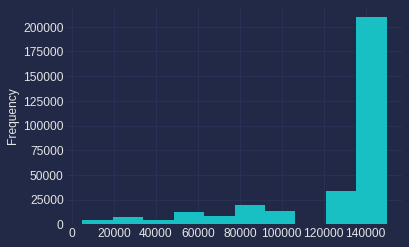

In [60]:
dt['Kilometer'].plot(kind = 'hist', bins = 10)

<AxesSubplot:>

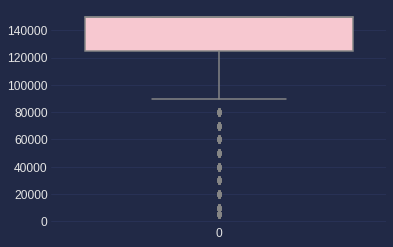

In [61]:
sns.boxplot(data = dt['Kilometer'], color = 'pink')

In [62]:
dt['Kilometer'].describe()

count    313619.000000
mean     128574.337014
std       36785.314787
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: Kilometer, dtype: float64

In [63]:
dt['Kilometer'].dtype

dtype('int64')

### **FuelType**

<AxesSubplot:>

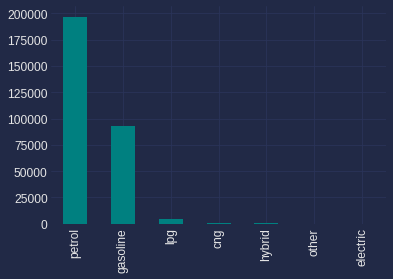

In [64]:
dt['FuelType'].value_counts().plot(kind = 'bar', color = 'teal')

In [65]:
dt['FuelType'] = dt['FuelType'].replace({'gasoline':'petrol', 'lpg':'gas','cng':'gas'})

* gasoline и petrol - бензин,
* a lpg & cng - газ

<AxesSubplot:>

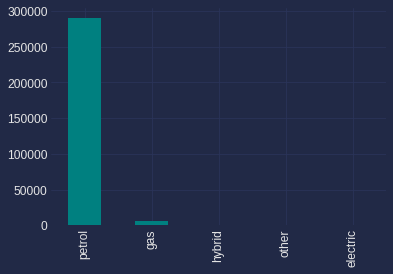

In [66]:
dt['FuelType'].value_counts().plot(kind = 'bar', color = 'teal')

In [67]:
dt['FuelType'].isna().sum()

17797

Замена аналогичная VehicleType & Gearbox

In [68]:
dt.loc[dt['FuelType'].isna()== True, 'FuelType'] = 'unkonw'

### Brand

gasoline и petrol - бензин,
a lpg & cng - газ

In [69]:
dt['Brand'].unique()

array(['volkswagen', 'audi', 'jeep', 'skoda', 'bmw', 'peugeot', 'ford',
       'mazda', 'nissan', 'renault', 'mercedes_benz', 'seat', 'honda',
       'fiat', 'opel', 'mini', 'smart', 'hyundai', 'alfa_romeo', 'subaru',
       'volvo', 'mitsubishi', 'kia', 'suzuki', 'lancia', 'citroen',
       'toyota', 'chevrolet', 'dacia', 'daihatsu', 'chrysler',
       'sonstige_autos', 'jaguar', 'daewoo', 'rover', 'porsche', 'saab',
       'land_rover', 'trabant', 'lada'], dtype=object)

<AxesSubplot:>

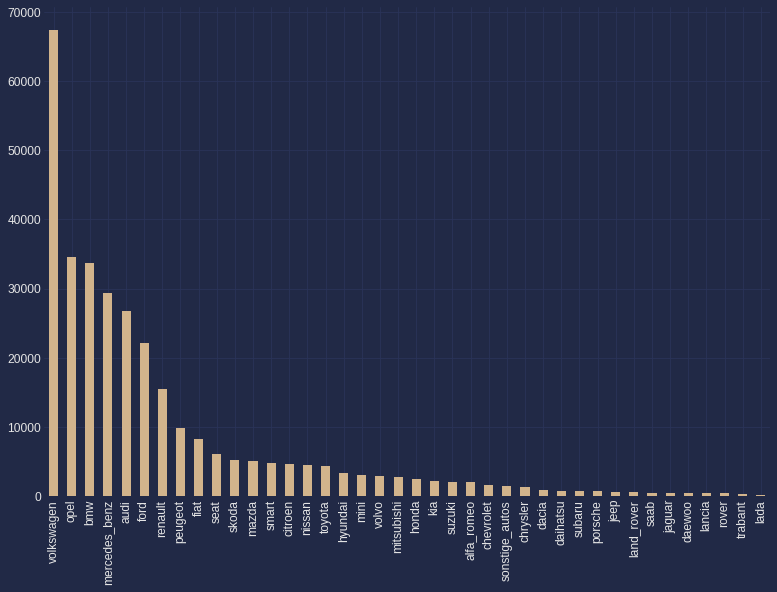

In [70]:
dt['Brand'].value_counts().sort_values(ascending = False).plot(kind = 'bar', figsize = [13,9], color = 'tan')

In [71]:
dt['Brand'].isna().sum()

0

### Repaired

<AxesSubplot:>

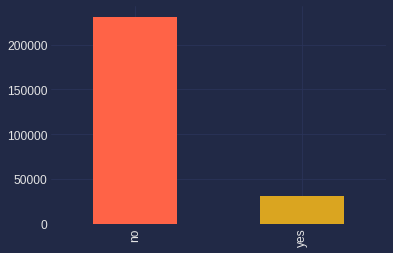

In [72]:
dt['Repaired'].value_counts().plot(kind = 'bar', color = ['tomato','goldenrod'])

In [73]:
dt['Repaired'].isna().sum()

51600

Присвоим такому большому количеств пропусков статус: 'Неизвестный'

In [74]:
dt.loc[dt['Repaired'].isna() == True, 'Repaired'] = 'unknow'

### Number Of Pictures

<AxesSubplot:>

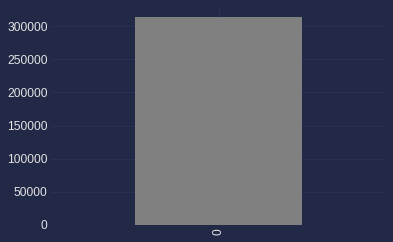

In [75]:
dt['NumberOfPictures'].value_counts().plot(kind = 'bar', color = 'gray')

In [76]:
dt[dt['NumberOfPictures'] > 0]

,Price,VehicleType,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired,NumberOfPictures,PostalCode,age,BM,Power_means


Абсолютное отсутствие изображений

In [77]:
dt_drop_columns['NumberOfPictures'] = dt['NumberOfPictures']

In [78]:
dt = dt.drop(columns = ['NumberOfPictures','BM','Power_means'])

### PostalCode

переменная связанная с регионом - возможно, будет доставлять лишний шум

In [79]:
len(dt['PostalCode'].unique())

8119

In [80]:
dt['PostalCode'].isna().sum()

0

Изменим тип данныx, чтобы потом закодировать в меньшие значения:

In [81]:
dt['PostalCode'] = dt['PostalCode'].astype(object)

### Итоговый осмотр:

**Гистограмы действительно количественных значений:**

array([[<AxesSubplot:title={'center':'Price'}>,
        <AxesSubplot:title={'center':'Power'}>],
       [<AxesSubplot:title={'center':'Kilometer'}>,
        <AxesSubplot:title={'center':'age'}>]], dtype=object)

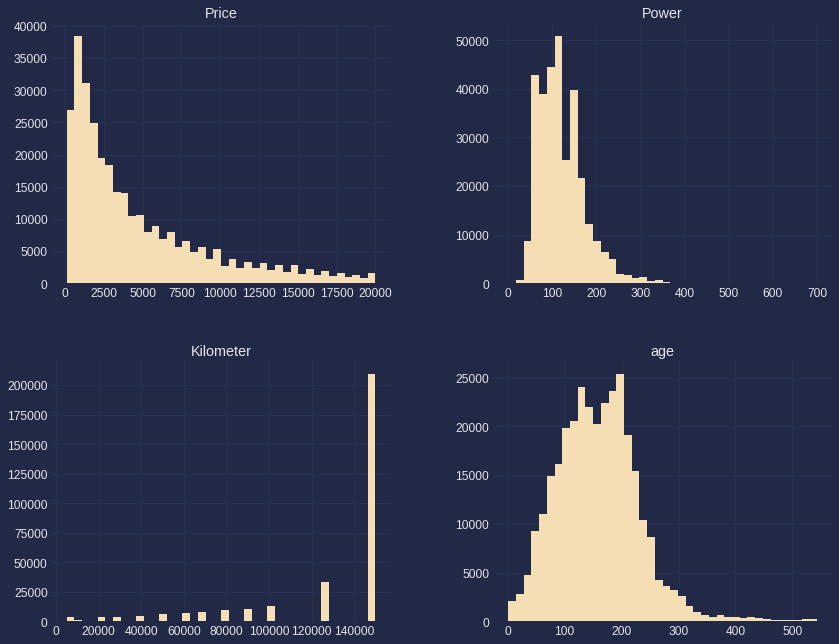

In [82]:
dt.hist(figsize = [14,11], bins = 40, color = ['wheat'])

**Корреляция числовых признаков:**

<AxesSubplot:>

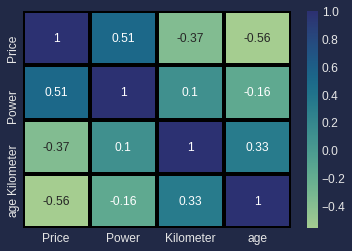

In [83]:
sns.heatmap(dt.corr(), annot = True, cmap ='crest', linewidths = 3, linecolor = 'black')

**Осмотрим значения категориальных столбцов:**

Top10 VehicleType :


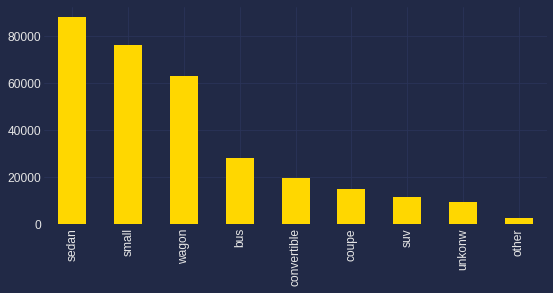

Top10 Gearbox :


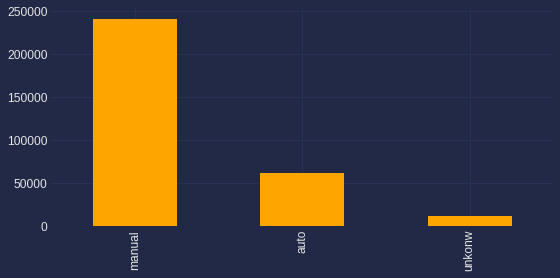

Top10 Model :


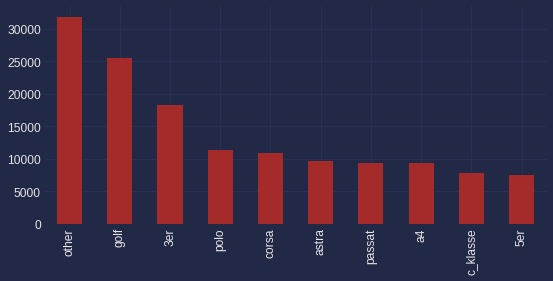

Top10 FuelType :


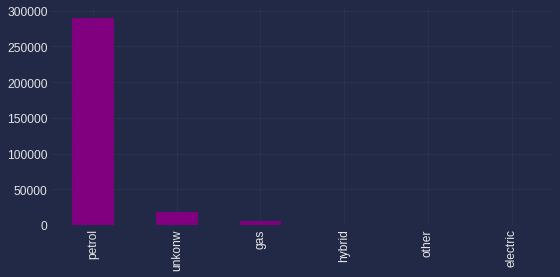

Top10 Brand :


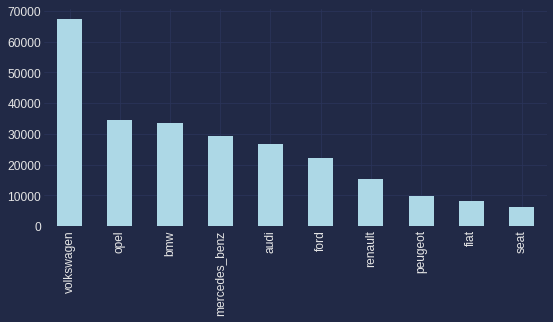

In [84]:
object_col = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']
color = ['gold','orange', 'brown', 'purple', 'lightblue']
for i,c in zip(object_col, color):
    print('Top10',i,':')
    
    dt[i].value_counts().sort_values(ascending = False).head(10).plot(kind = 'bar', color = [c], figsize = [9,4])
    
    plt.show()

**Нули:**

In [85]:
dt.isna().sum()

Price          0
VehicleType    0
Gearbox        0
Power          0
Model          0
Kilometer      0
FuelType       0
Brand          0
Repaired       0
PostalCode     0
age            0
dtype: int64

In [86]:
dt = dt.reset_index()

## Подготовка данных к работе с моделями (Кодирование и стандартизация):

**В данном разделе будут закодированы категориальные столбцы и, с расчетем на дальнейший градиентный спуск - стандартизированы данные**

**Разобьем DataFrame на категориальные и числовые прризнаки**

In [87]:
obj_col = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired','PostalCode']
int_col = ['Power','Kilometer','age']

In [88]:
dt_obj,dt_int,dt_obj_full = dt.loc[:,obj_col],dt.loc[:,int_col],dt.loc[:,obj_col]

In [89]:
dt_target = dt['Price']

In [90]:
dt_features = dt.drop(columns = ['Price'], axis = 1)

### **Train test split**

Выборка для дерева:
* Trian Ordinal Encoder
* Valid Ordinal Encoder 
* Test Ordinal Encoder

Выборка дла бустинга:
* Train STD(int)
* Valid STD(int)
* Test STD(int)

In [91]:
x_train, x_next, y_train, y_next = train_test_split(dt_features, dt_target, train_size = 0.65, random_state = 1667)

x_valid, x_test, y_valid, y_test = train_test_split(x_next, y_next, train_size = 0.5, random_state = 1667) 

In [92]:
print(x_train.shape, x_valid.shape, x_test.shape)

(203852, 11) (54883, 11) (54884, 11)


In [93]:
xt_train_int, xt_train_obj = x_train.loc[:,int_col], x_train.loc[:, obj_col]
xt_valid_int, xt_valid_obj = x_valid.loc[:,int_col], x_valid.loc[:, obj_col]
xt_test_int, xt_test_obj   = x_test.loc[:,int_col], x_test.loc[:, obj_col]

In [94]:
xs_train_int, xs_train_obj = x_train.loc[:,int_col], x_train.loc[:, obj_col]
xs_valid_int, xs_valid_obj = x_valid.loc[:,int_col], x_valid.loc[:, obj_col]
xs_test_int, xs_test_obj   = x_test.loc[:,int_col], x_test.loc[:, obj_col]

### **OrdinalEncoder:**

In [95]:
ordenc = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value = 9999 ) #handle_unknown = 'use_encoded_value', unknown_value = 3

In [96]:
ordenc.fit(xt_train_obj)
xt_train_obj = pd.DataFrame(ordenc.transform(xt_train_obj), index = xt_train_int.index)
xt_valid_obj = pd.DataFrame(ordenc.transform(xt_valid_obj), index = xt_valid_int.index)
xt_test_obj  = pd.DataFrame(ordenc.transform(xt_test_obj),  index = xt_test_int.index)

### **StandartScaler:**

In [97]:
stdsc = StandardScaler()

In [98]:
stdsc.fit(xs_train_int)
xs_train_int = pd.DataFrame(stdsc.transform(xs_train_int), index = xs_train_obj.index)
xs_valid_int = pd.DataFrame(stdsc.transform(xs_valid_int),index = xs_valid_obj.index)
xs_test_int  = pd.DataFrame(stdsc.transform(xs_test_int),index = xs_test_obj.index)

### **Объединение трансформированных выборок:**

#### **Для решающего дерева**

In [99]:
xt_train = pd.merge(xt_train_int, xt_train_obj, left_index = True, right_index = True)
xt_valid = pd.merge(xt_valid_int, xt_valid_obj, left_index = True, right_index = True)
xt_test  = pd.merge(xt_test_int, xt_test_obj,   left_index = True, right_index = True)

#### **Для бустинга**


In [100]:
xs_train = xs_train_int.join(xs_train_obj)
xs_valid = xs_valid_int.join(xs_valid_obj)
xs_test  = xs_test_int.join(xs_test_obj)

## Обучение моделей

### RandomForestRegressor

In [101]:
best_model = None
best_result = 10000
best_est = 0
best_depth = 0

for est in [25, 50, 100]:
    for depth in [None,2,4,6]:
        rfr = RandomForestRegressor(random_state = 1667, n_estimators = est, max_depth = depth)
        rfr.fit(xt_train,y_train)
        rfr_predict = rfr.predict(xt_valid)
        result = sqrt(mse(y_valid, rfr_predict))
        if result < best_result:
            best_model = rfr
            best_result = result
            best_est = est
            best_depth = depth

#### **Строим модель с лучшими гиперпараметрами, предсказывая валидационную выборку:**

In [102]:
rfr_start = time.perf_counter()

rfr = best_model                   #Обучение
rfr.fit(xt_train,y_train)

rfr_stop = time.perf_counter()
rfr_time_fit = round((rfr_stop - rfr_start) * 1000)

rfr_start = time.perf_counter()

y_pred = rfr.predict(xt_valid) # предсказание

rfr_stop = time.perf_counter()
rfr_time_predict = round((rfr_stop - rfr_start) * 1000)

rfr_std = sqrt(mse(y_valid, y_pred))

### CatBoostRegressor

In [103]:
cat = CatBoostRegressor(loss_function = 'RMSE')
cat_par = {'depth':[6,9], 'learning_rate':np.arange(0.03, 0.1, 0.25)}
cat_grid = cat.grid_search(cat_par, Pool(xs_train,y_train, cat_features = obj_col),
                          cv = 3, verbose = True, plot = False)

0:	learn: 6411.8493769	test: 6370.5879868	best: 6370.5879868 (0)	total: 380ms	remaining: 6m 19s
1:	learn: 6250.7253764	test: 6209.4102799	best: 6209.4102799 (1)	total: 733ms	remaining: 6m 5s
2:	learn: 6095.4919875	test: 6054.7733580	best: 6054.7733580 (2)	total: 1.01s	remaining: 5m 36s
3:	learn: 5946.6498088	test: 5905.6283139	best: 5905.6283139 (3)	total: 1.35s	remaining: 5m 35s
4:	learn: 5800.7381794	test: 5759.1468831	best: 5759.1468831 (4)	total: 1.62s	remaining: 5m 22s
5:	learn: 5660.8616827	test: 5620.5636275	best: 5620.5636275 (5)	total: 1.87s	remaining: 5m 9s
6:	learn: 5525.9520945	test: 5485.4539269	best: 5485.4539269 (6)	total: 2.16s	remaining: 5m 7s
7:	learn: 5394.6277578	test: 5354.3339976	best: 5354.3339976 (7)	total: 2.44s	remaining: 5m 2s
8:	learn: 5267.7706708	test: 5227.2958588	best: 5227.2958588 (8)	total: 2.66s	remaining: 4m 53s
9:	learn: 5144.6511754	test: 5104.1505953	best: 5104.1505953 (9)	total: 2.96s	remaining: 4m 53s
10:	learn: 5025.4227401	test: 4984.4362285	b

#### **Строим лучшею модель с подобранными гиперпараметрами, предсказывая валидационную выборку:**

In [104]:
cat_start = time.perf_counter()
cat = CatBoostRegressor(cat_features = obj_col, depth = cat_grid["params"]['depth'],
                       learning_rate = cat_grid["params"]['learning_rate'], loss_function = 'RMSE', verbose = 100)
cat.fit(xs_train,y_train)
cat_stop = time.perf_counter()
cat_time_fit = round((cat_stop - cat_start) * 1000)

cat_start = time.perf_counter()
catpred = cat.predict(xs_valid)
cat_stop = time.perf_counter()
cat_time_pred = round((cat_stop - cat_start) * 1000)

cat_std = sqrt(mse(y_valid, catpred))

0:	learn: 4458.0674913	total: 485ms	remaining: 8m 4s
100:	learn: 1801.3944059	total: 52.6s	remaining: 7m 48s
200:	learn: 1665.6886920	total: 1m 41s	remaining: 6m 42s
300:	learn: 1617.4408308	total: 2m 27s	remaining: 5m 42s
400:	learn: 1584.4493413	total: 3m 14s	remaining: 4m 50s
500:	learn: 1556.5907995	total: 4m 4s	remaining: 4m 3s
600:	learn: 1536.9335646	total: 4m 53s	remaining: 3m 14s
700:	learn: 1520.9104714	total: 5m 42s	remaining: 2m 26s
800:	learn: 1506.4803654	total: 6m 31s	remaining: 1m 37s
900:	learn: 1493.8028193	total: 7m 20s	remaining: 48.3s
999:	learn: 1482.3499126	total: 8m 8s	remaining: 0us


### LightGBM

In [105]:
forgbm = [xs_train,xs_valid,xs_test]

In [106]:
for m in forgbm:
    for i in obj_col:
        m[i] = m[i].astype('category')

In [107]:
lgbmP = {'n_estimatoros' : [100, 150, 200], 'learning_rate' : [0.1,0.2,0.4]}

In [108]:
lgbm = LGBMRegressor(random_state = 1667)
lgbm_par = GridSearchCV(estimator = lgbm,
                       param_grid = lgbmP, scoring = 'neg_root_mean_squared_error',
                       cv = 3,
                       verbose = 10)
lgbm_par.fit(xs_train,y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3; 1/9] START learning_rate=0.1, n_estimatoros=100........................
[LightGBM] [Warning] Unknown parameter: n_estimatoros
[CV 1/3; 1/9] END ......learning_rate=0.1, n_estimatoros=100; total time=  12.9s
[CV 2/3; 1/9] START learning_rate=0.1, n_estimatoros=100........................
[LightGBM] [Warning] Unknown parameter: n_estimatoros
[CV 2/3; 1/9] END ......learning_rate=0.1, n_estimatoros=100; total time=  12.9s
[CV 3/3; 1/9] START learning_rate=0.1, n_estimatoros=100........................
[LightGBM] [Warning] Unknown parameter: n_estimatoros
[CV 3/3; 1/9] END ......learning_rate=0.1, n_estimatoros=100; total time=  13.4s
[CV 1/3; 2/9] START learning_rate=0.1, n_estimatoros=150........................
[LightGBM] [Warning] Unknown parameter: n_estimatoros
[CV 1/3; 2/9] END ......learning_rate=0.1, n_estimatoros=150; total time=  13.0s
[CV 2/3; 2/9] START learning_rate=0.1, n_estimatoros=150....................

GridSearchCV(cv=3, estimator=LGBMRegressor(random_state=1667),
             param_grid={'learning_rate': [0.1, 0.2, 0.4],
                         'n_estimatoros': [100, 150, 200]},
             scoring='neg_root_mean_squared_error', verbose=10)

In [109]:
display(lgbm_par.best_params_)

{'learning_rate': 0.2, 'n_estimatoros': 100}

#### **Строим модель по найденным гиперпараметрам, предсказывая валидационную выборку:**

In [110]:
lgbm_start = time.perf_counter()
lgbm = LGBMRegressor(random_state = 1667, n_estimators = 100, learning_rate = 0.2).fit(xs_train,y_train, categorical_feature = obj_col)
lgbm_stop = time.perf_counter()
lgbm_time_fit = round((lgbm_stop - lgbm_start) * 1000)



lgbm_start = time.perf_counter()
lgbm_pred = lgbm.predict(xs_valid)

lgbm_stop = time.perf_counter()
lgbm_time_pred = round((lgbm_stop - lgbm_start) * 1000)


lgbm_std = sqrt(mse(y_valid, lgbm_pred))

/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


## Анализ моделей

In [111]:
d = {'RandomForestRegressor':[rfr_std,rfr_time_fit,rfr_time_predict],
    'CatBoostRegressor': [cat_std, cat_time_fit, cat_time_pred], 'LGBMRegressor':[lgbm_std, lgbm_time_fit, lgbm_time_pred]}
answer = pd.DataFrame(data = d, index = ['Validation RMSE','time fit MS','time pred MS'])

display(answer)

,RandomForestRegressor,CatBoostRegressor,LGBMRegressor
Validation RMSE,1568.355705,1584.978533,1614.764715
time fit MS,87554.000000,495511.000000,14876.000000
time pred MS,3438.000000,2370.000000,702.000000


* Дольше всех учится CatBoostRegressor - 8 минут. Быстрее всех - LGBMRegressor -около 15 секунд. 
* Cамое точное предсказание(RMSE) у модели RandomForestRegressor - 1568, Наименее точная - LGBMRegressor - 1614.
* Быстрее всех предсказание выдает LGBMRegressor = 708ms, Дольше всех RandomForestRegressor - 3438ms

## **Тестирование выбранной модели:**

Среди моделей выберем самую подходящую по критериям заказчика и протестируем её:

In [112]:
print('Результаты выбранной модели на тестовой выборке:')
lg_start = time.perf_counter()
lgbmbest = LGBMRegressor(random_state = 1667, n_estimators = 100, learning_rate = 0.2).fit(
    xs_train,y_train, categorical_feature = obj_col)
lg_stop = time.perf_counter()
print('Скорость обучения модели LGBMRegressor:')
print(best_time_fit := round((lg_stop - lg_start)* 1000))

      
print('Время предсказания модели:')
lg_start = time.perf_counter()      
test_pred = lgbmbest.predict(xs_test)
lg_stop = time.perf_counter()
print(best_time_pred := round((lg_stop - lg_start)*1000))
      



print('Итоговое значение RMSE на тестовой выборке:')
print(RMSE := sqrt(mse(y_test,test_pred)))


Результаты выбранной модели на тестовой выборке:


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


Скорость обучения модели LGBMRegressor:
14643
Время предсказания модели:
704
Итоговое значение RMSE на тестовой выборке:
1583.989976215025


**Для выбранной модели проведем анализ наиболее влиятельных признаков:**

<AxesSubplot:xlabel='Features'>

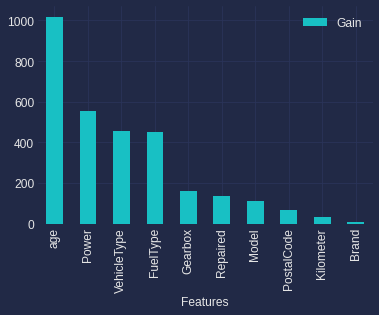

In [114]:
gain_importance = lgbmbest.feature_importances_
dt_features = dt_features.drop(columns = ['index'])
feature_names  = dt_features.columns

gid = pd.DataFrame({'Features': feature_names, 'Gain': gain_importance})
gid = gid.sort_values(by = 'Gain', ascending = False).reset_index().drop(columns = 'index')
gid.plot(x = 'Features', kind = 'bar')

## Общий вывод:

1. Была проведена первичная обработка данных, в результате которой былы:
* Удалены признаки будущего времени, признаки не связанные с ценообразованием и признаки имеющие только одно значение.
* Обработаны пропуски в данных.
* Создан новый признак возраста машины.
2. Для качественной проверки моделей были выполнены
* Кодирование признаков
* Стандартизация признаков
3. Для сравнения моделей, с улучшением их качества были:
* Проведен перебор по гиперпараметрам
* С лучшими из обнаруженных гиперпараметров были замерены скорость обучения и предсказания у избранных моделей:

In [115]:
display(answer)

,RandomForestRegressor,CatBoostRegressor,LGBMRegressor
Validation RMSE,1568.355705,1584.978533,1614.764715
time fit MS,87554.000000,495511.000000,14876.000000
time pred MS,3438.000000,2370.000000,702.000000


4. Для избранной модели выявлены самые влиятельные на стоимость признаки:
- Age - возраст автомобиля
- Power - мощность двигателя автомобиля

Cоответственнос с критериями, которые важны заказчику, а именно:
* качество предсказания
* время обучения модели
* время предсказания модели


**Наибиолее подходящей моделью является LightGBMRegressor(LGBMRegressor), опережающей остальные модели по показателям скорость, но незначительно(3,2% от RandomForestRegressor;  2,7% от CatBoostRegressor) отствая в точности предсказания.**
* Гиперпараметры LGBMRegressor: n_estimators = 100, learning_rate = 0,2